# Probing t scaling

This is a notebook designed to display the different derivatives of the stress and strain developed from a sinc style manipulation. Crucially, it aims to show how the fundamental manipulation frequency affects the disparity between teh avergae magnitudes of the different derivatives. The eventual aim relies on the idea that the effective fundamental frequency after scaling the produces the lowest disparity may be the optimal one to scale towards for the general problem.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

sys.path.append('../src')
import deepymod_torch.VE_datagen as VE_datagen

np.random.seed(0)

## Single omega viewing

### Data generation

#### Model Params

Describe the model being built. The input_type is a very important paramter, as it doesn't just switch the role of stress and strain, between which is the sinc curve and which is the response, it also decides the interpretation of the model parameters. If the input type is strain, they are interpreted as if describing a Maxwell model, and if the input type is stress, they are interpreted as if describing a Kelvin model.

In [ ]:
input_type = 'Strain'

In [3]:
E = [5e-4, 5e-4, 5e-4]
eta = [1e-3, 2.2e-4]
diff_order = len(eta)

#### Manipulation params

Specify the functional form of the input

In [2]:
# sinc
omega = 2*np.pi
Amp = 7
input_expr = lambda t: Amp*np.sin(omega*t)/(omega*t)
d_input_expr = lambda t: (Amp/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))

#### Generating series

Specify the independant data points over which to synthesise the data.

In [4]:
time_array = np.linspace(10**-10, 10*np.pi/omega, 5000).reshape(-1, 1)

Calculate the manipulation and response.

In [5]:
strain_array, stress_array = VE_datagen.calculate_strain_stress(input_type, time_array, input_expr, E, eta, D_input_lambda=d_input_expr)

### Derivative calculations

Determine how the data should be scaled. In this initial example, we do not scale the time series, to demonstrate what happens if it is not scaled.

In [6]:
time_sf = 1
strain_sf = 1/np.max(abs(strain_array))
stress_sf = 1/np.max(abs(stress_array))

scaled_time_array = time_array*time_sf
scaled_strain_array = strain_array*strain_sf
scaled_stress_array = stress_array*stress_sf

We calculate all derivatives for stress and strain using np.gradient, a numerical derivatives function.

In [7]:
strain_theta = VE_datagen.num_derivs(scaled_strain_array, scaled_time_array, diff_order)
stress_theta = VE_datagen.num_derivs(scaled_stress_array, scaled_time_array, diff_order)

### Plotting

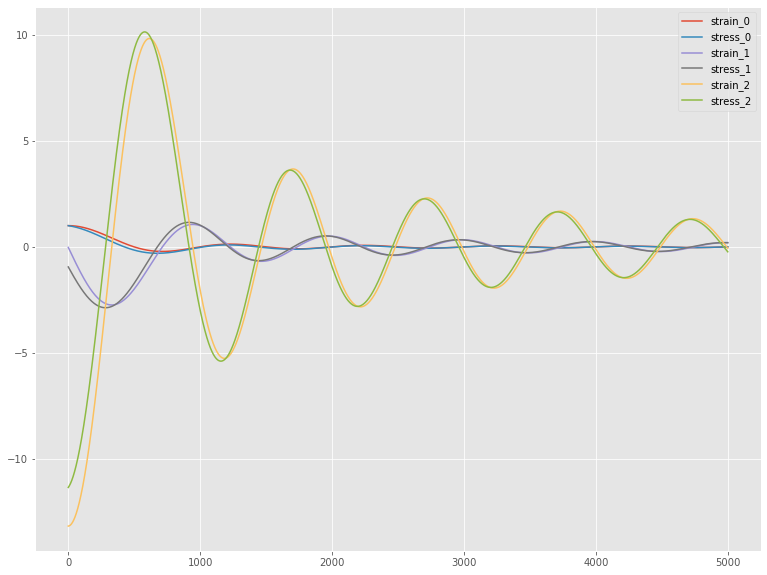

In [8]:
plt.figure(figsize=(13,10))
for i in range(strain_theta.shape[1]):
    plt.plot(strain_theta[diff_order:-diff_order, i], label='strain_'+str(i))
    plt.plot(stress_theta[diff_order:-diff_order, i], label='stress_'+str(i))

plt.legend()

## Looping omega

In this section we perform an analysis like above but to many different time scalings in turn, so see the affect that changing the scaled fundamental frequency has. Beyond simply plotting many graphs, we find the avergae magnitude of each derivative for each scaling, and show how the disparity between these averages chnages for each scaling.

### Data Generation

In [ ]:
input_type = 'Strain'

In [10]:
E = [5e-4, 5e-4, 5e-4]
eta = [1e-3, 2.2e-4]
diff_order = len(eta)

In [11]:
omega = 2*np.pi
Amp = 7
input_expr = lambda t: Amp*np.sin(omega*t)/(omega*t)
d_input_expr = lambda t: (Amp/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))

In [12]:
time_array = np.linspace(10**-10, 10*np.pi/omega, 5000).reshape(-1, 1)
strain_array, stress_array = VE_datagen.calculate_strain_stress(input_type, time_array, input_expr, E, eta, D_input_lambda=d_input_expr)

### Y axis scaling only

In [13]:
strain_sf = 1/np.max(abs(strain_array))
stress_sf = 1/np.max(abs(stress_array))

scaled_strain_array = strain_array*strain_sf
scaled_stress_array = stress_array*stress_sf

### Set up effective scaled omega for each iteration of loop.

Then calculate the required scale factors needed to acheive this.

In [14]:
scaled_omega_values = np.linspace(0.05, 3, 2001)
time_sf_values = omega/scaled_omega_values

### Main loop

In [16]:
av_derivs = np.empty((0, 2*(diff_order+1))) # For concatenation
for time_sf in time_sf_values:    
    # Scale time series differently each time
    scaled_time_array = time_array*time_sf
    
    # Recalculate derivatives wrt new time series
    strain_theta = VE_datagen.num_derivs(scaled_strain_array, scaled_time_array, diff_order)
    stress_theta = VE_datagen.num_derivs(scaled_stress_array, scaled_time_array, diff_order)
    
    # Find average magnitude of all derivatives
    theta = np.concatenate((strain_theta, stress_theta), axis=1)
    av_derivs_single_sf = np.mean(abs(theta[diff_order:-diff_order, :]), axis=0).reshape(1, -1)
    
    # Concatenate with series of averages for each scaling so far
    av_derivs = np.concatenate((av_derivs, av_derivs_single_sf), axis=0)

### Plotting

First plot how average magnitude of each derivative varies with different scaled omega.

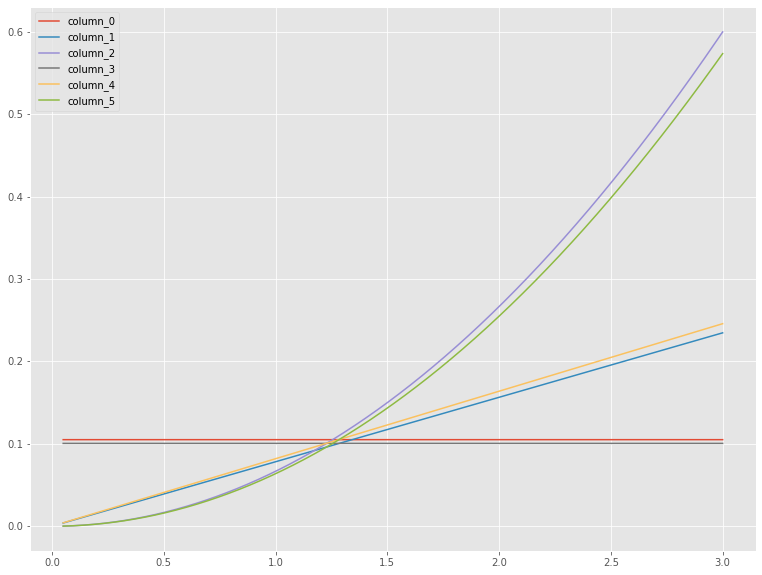

In [17]:
plt.figure(figsize=(13,10))
for i in range(av_derivs.shape[1]):
    plt.plot(scaled_omega_values, av_derivs[:, i], label='column_'+str(i))

plt.legend()

## Finding lowest disparity

Quantify the disparity between terms by finding the standard deviation between the average magnitude of each term. Plot this disparity for each scaling.

In [18]:
disparity = np.std(av_derivs, axis=1)

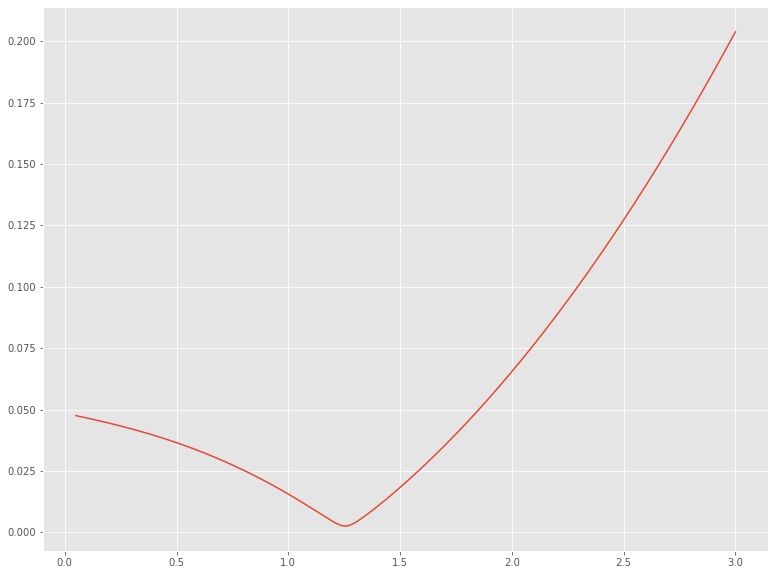

In [19]:
plt.figure(figsize=(13,10))
plt.plot(scaled_omega_values, disparity)

#### Optimum

We locate the best effective scaled omega by finding the value on the x axis that corresponds to the minimum disparity (y axis).

In [20]:
best_scaled_omega_index = np.argmin(disparity)
best_scaled_omega = scaled_omega_values[best_scaled_omega_index]
best_scaled_omega

1.2550750000000002